In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import spacy



import warnings
warnings.filterwarnings('ignore')

In [4]:
#classifying news categories
df = pd.read_json("news_dataset.json")
print(df.shape)
df.head()

(12695, 2)


,text,category
0,Watching Schrödinger's Cat Die University of C...,SCIENCE
1,WATCH: Freaky Vortex Opens Up In Flooded Lake,SCIENCE
2,Entrepreneurs Today Don't Need a Big Budget to...,BUSINESS
3,These Roads Could Recharge Your Electric Car A...,BUSINESS
4,Civilian 'Guard' Fires Gun While 'Protecting' ...,CRIME


In [5]:
#perform preprocessing
df['category'].value_counts()

category
BUSINESS    4254
SPORTS      4167
CRIME       2893
SCIENCE     1381
Name: count, dtype: int64

In [6]:
#remove stop words and apply lemmatization
nlp = spacy.load('en_core_web_sm')
def preprocess(text):
    non_stopwords = []
    doc = nlp(text)
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        non_stopwords.append(token.lemma_)
    return " ".join(non_stopwords)
    

In [7]:
df['new_text'] = df['text'].apply(preprocess)

In [8]:
df['new_category'] = df['category'].map({'BUSINESS':0,
                                     'SPORTS':1,
                                     'CRIME':2,
                                     'SCIENCE':3})

In [9]:
df.head()

,text,category,new_text,new_category
0,Watching Schrödinger's Cat Die University of C...,SCIENCE,watch Schrödinger Cat Die University Californi...,3
1,WATCH: Freaky Vortex Opens Up In Flooded Lake,SCIENCE,WATCH Freaky Vortex Opens Flooded Lake,3
2,Entrepreneurs Today Don't Need a Big Budget to...,BUSINESS,entrepreneur today need Big Budget start year ...,0
3,These Roads Could Recharge Your Electric Car A...,BUSINESS,road recharge Electric Car drive high tech hig...,0
4,Civilian 'Guard' Fires Gun While 'Protecting' ...,CRIME,Civilian Guard Fires Gun protect Recruiting Ce...,2


In [10]:
#drop the irrelevant features
new_df = df.drop(['text','category'], axis=1)
new_df.head()

,new_text,new_category
0,watch Schrödinger Cat Die University Californi...,3
1,WATCH Freaky Vortex Opens Flooded Lake,3
2,entrepreneur today need Big Budget start year ...,0
3,road recharge Electric Car drive high tech hig...,0
4,Civilian Guard Fires Gun protect Recruiting Ce...,2


In [11]:
#convert text column to vector using n-grams
vec = CountVectorizer(ngram_range=(1,2))
X = vec.fit_transform(new_df['new_text'])
#convert sparse matrix to dataframe directly
text_vector = pd.DataFrame.sparse.from_spmatrix(X, columns=vec.get_feature_names_out())
#merge dataframe
new_df = pd.concat([new_df.reset_index(drop=True),text_vector.reset_index(drop=True)],axis=1)
#print new dataframe
new_df.head()


,new_text,new_category,00,00 00,00 era,00 remember,00 sit,00 test,000,000 15,...,zurlon,zurlon tipton,zuzu,zuzu verk,zweig,zweig cern,zyberk,zyberk ceo,éga,éga liberté
0,watch Schrödinger Cat Die University Californi...,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,WATCH Freaky Vortex Opens Flooded Lake,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,entrepreneur today need Big Budget start year ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,road recharge Electric Car drive high tech hig...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Civilian Guard Fires Gun protect Recruiting Ce...,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
new_df['new_category'].value_counts()

new_category
0    4254
1    4167
2    2893
3    1381
Name: count, dtype: int64

In [13]:
#since the dataset is imbalanced, use smote analysis

In [14]:
#handle imbalance with SMOTE
X  = new_df.drop(['new_text', 'new_category'], axis=1)
y = new_df['new_category']

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled,y_resampled = smote.fit_resample(X, y)
df_resampled = pd.DataFrame(X_resampled)
df_resampled['category'] = y_resampled


In [15]:
df_resampled['category'].value_counts()

category
3    4254
0    4254
2    4254
1    4254
Name: count, dtype: int64

In [16]:
#split the dataset
X_train, X_test, y_train, y_test = train_test_split(df_resampled.drop(['category'],axis=1),df_resampled['category'],
                                                   test_size=0.2, random_state=42)
len(X_train), len(X_test)

(13612, 3404)

In [17]:
#train with multinomialNB model
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [18]:
y_pred = model.predict(X_test)

In [19]:
y_test[:7]

3682    2
7660    1
7217    2
4816    3
7724    1
59      2
5528    1
Name: category, dtype: int64

In [20]:
y_pred[:7]

array([2, 1, 2, 3, 1, 2, 1], dtype=int64)

In [21]:
#print classification report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       839
           1       0.90      0.90      0.90       846
           2       0.88      0.77      0.83       883
           3       0.80      0.84      0.82       836

    accuracy                           0.85      3404
   macro avg       0.86      0.85      0.85      3404
weighted avg       0.86      0.85      0.85      3404



Text(58.222222222222214, 0.5, 'Truth')

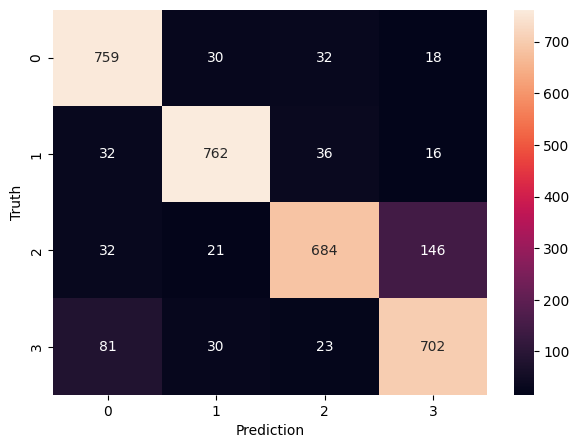

In [22]:
#plot confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test,y_pred)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')

In [23]:
#Alternative method using imblearn pipeline
df.head()

,text,category,new_text,new_category
0,Watching Schrödinger's Cat Die University of C...,SCIENCE,watch Schrödinger Cat Die University Californi...,3
1,WATCH: Freaky Vortex Opens Up In Flooded Lake,SCIENCE,WATCH Freaky Vortex Opens Flooded Lake,3
2,Entrepreneurs Today Don't Need a Big Budget to...,BUSINESS,entrepreneur today need Big Budget start year ...,0
3,These Roads Could Recharge Your Electric Car A...,BUSINESS,road recharge Electric Car drive high tech hig...,0
4,Civilian 'Guard' Fires Gun While 'Protecting' ...,CRIME,Civilian Guard Fires Gun protect Recruiting Ce...,2


In [24]:
category_map = {'BUSINESS':0,'SPORTS':1,'CRIME':2,'SCIENCE':3}
df['category'] = df['category'].map(category_map)


In [25]:
df = df.drop(['new_category'],axis=1)
df.head()

,text,category,new_text
0,Watching Schrödinger's Cat Die University of C...,3,watch Schrödinger Cat Die University Californi...
1,WATCH: Freaky Vortex Opens Up In Flooded Lake,3,WATCH Freaky Vortex Opens Flooded Lake
2,Entrepreneurs Today Don't Need a Big Budget to...,0,entrepreneur today need Big Budget start year ...
3,These Roads Could Recharge Your Electric Car A...,0,road recharge Electric Car drive high tech hig...
4,Civilian 'Guard' Fires Gun While 'Protecting' ...,2,Civilian Guard Fires Gun protect Recruiting Ce...


In [26]:
#drop text column
df = df.drop(['text'], axis=1)

In [27]:
#split the dataset
x_train, x_test, y_train, y_test = train_test_split(df['new_text'],df['category'], test_size=0.2, random_state=42,
                                                   stratify=df['category'])
print(x_train.shape)
x_train[:5]

(10156,)


4661    Dad arrest death 3 year Old say choke Milk Pol...
7601                      trick help People Racist Sexist
2116    flint like Lead Hazards lurk private Water Wel...
4976    sentence come Man loan Gun Boston Marathon Bom...
9415    2015 WWE Elimination Chamber Matches late rumo...
Name: new_text, dtype: object

In [28]:
#build a pipleline using make-pipeline from imblearn as it can hanlde smote's fit_resample better than sklearn pipeline
from imblearn.pipeline import make_pipeline
clf = make_pipeline(
                    CountVectorizer(ngram_range=(1,1)), #text vectorization
                    SMOTE(), #handling category imbalance
                    MultinomialNB()  #classification model
                    ) 
            
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)

In [29]:
x_test[:5]

775     Greg Hardy go play Sunday apologize nearly yea...
7434    help People Disabilities Tap ability people di...
8863    russian Medallist Winter Olympics suspect Dopi...
3741    test taste Journey Coffee Bean coffee depend s...
8586          10 big Ways Government waste Taxpayer Money
Name: new_text, dtype: object

In [30]:
y_test[:5]

775     1
7434    0
8863    1
3741    0
8586    0
Name: category, dtype: int64

In [31]:
y_pred[:5]

array([1, 0, 1, 0, 0], dtype=int64)

In [32]:
#predicting user input
user_input = input("Enter the News Article: ")
#predict the category
predicted_category_num = clf.predict([user_input])[0]
#map the numericl output back to the category name
reverse_mapping = {value: key for key, value in category_map.items()}
predicted_category = reverse_mapping[predicted_category_num]
print(f"The News Category is: {predicted_category}")

Enter the News Article: get a car from tesla
The News Category is: BUSINESS


In [33]:
import joblib
joblib.dump(clf, 'news_category_model.pkl')

['news_category_model.pkl']

In [34]:
import streamlit as st

# Load the saved model
model = joblib.load('news_category_model.pkl')

# Define the categories (adjust as per your mapping)
category_mapping = {'BUSINESS':0,'SPORTS':1,'CRIME':2,'SCIENCE':3}

# Streamlit app
st.title("News Category Prediction")
st.write("Enter a news headline to predict its category.")

text_input = st.text_input("News Headline")

if st.button("Predict"):
    if text_input:
        prediction = model.predict([text_input])[0]
        category = category_mapping[prediction]
        st.write(f"Predicted Category: {category}")
    else:
        st.write("Please enter a news headline.")


2025-03-30 23:26:05.712 
  command:

    streamlit run C:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


In [35]:
!streamlit run app.py



Usage: streamlit run [OPTIONS] TARGET [ARGS]...
Try 'streamlit run --help' for help.

Error: Invalid value: File does not exist: app.py
